# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Added for a progress bar
from tqdm import tqdm

from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate

# Import for analysising model predicted results
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

/Users/manaschinthalapati/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [34]:
# import the urllib library
import urllib.request

#variable used to store the number of files to be used the the ratio between train and test data
files=5
ratio=0.75
data = {}

#loop to store all the data
for i in range(1,files+1):
# Copy a network object to a local file
    name = 'neutrino'+str(i)+'.h5'
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', name)
    image=h5py.File(name,'r')
    data[i]=image
#Open the local h5 file with h5py
    df=h5py.File('neutrino1.h5','r')

In [4]:
#Print the keys in the neutrino meta data
print(df.keys())
print(df['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df['cvnmap']))
print(df['neutrino']['evt'])
event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(7001, 16000)
<HDF5 dataset "evt": shape (7001, 1), type "<u4">


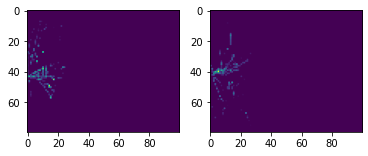

In [5]:
#Plot the first event, look it is a nice long muon track
fig, ax = plt.subplots(1,2)
ax[0].imshow(event0[1].T)
ax[1].imshow(event0[0].T)

In [6]:
print("Neutrino Final State code",df['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df['neutrino']['interaction'][3]))
print("Neutrino energy",df['neutrino']['nuenergy'][3],"GeV")
print("Lepton energy",df['neutrino']['lepenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV
Lepton energy [2.7689836] GeV


(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.      ,  8.229538, 16.459076, 24.688614, 32.91815 , 41.14769 ,
        49.377228, 57.606766, 65.8363  , 74.06584 , 82.29538 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

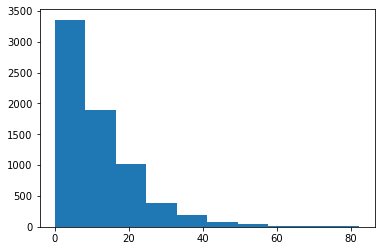

In [7]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy) #neutrino energy histogram

In [8]:
#imports data from the first file and creates and array for images and labels
images = np.array(data[1]['cvnmap'], dtype='float')
labels= np.array(data[1]['neutrino']['interaction'],dtype='uint8')

#loop that adds more data from the number of specified at the beggining
for i in range(2,files):
    images = np.concatenate((images , np.array(data[i]['cvnmap'], dtype = 'uint8') ))  
    labels= np.concatenate((labels , np.array(data[i]['neutrino']['interaction'], dtype='uint8') )) 

#the catagory array is used to store the actual values corresponding to the interaction type, to be used later
catagory=labels
catagory = catagory.reshape(len(catagory))
#convertes labels to booleon
labels= np.where( labels <= 3, 1,0).astype(bool)
#reshapes the image array to fit the CNN input
images = images.reshape((images.shape[0],100,80,2))#.transpose(0,2,3,1)
print(np.shape(images))
print(np.shape(labels))

(21003, 100, 80, 2)
(21003, 1)


In [9]:
#shuffle all of the data to ensure data is randomly distributed
perm = np.random.permutation(len(labels))

#make sure to shuffle all arrays together so that elemetns still correspond correctly
images_shuffle = images[perm]
labels_shuffle = labels[perm]
catagory_shuffle = catagory[perm]

In [10]:
#splits the data into train and test with the ratio specified at the begining, also splitting catagory array 
train_images, test_images, train_labels, test_labels, train_catagory, test_catagory = train_test_split(images_shuffle, labels_shuffle, catagory_shuffle, test_size=1-ratio)
print(np.shape(train_images))
print(np.shape(train_labels))

(15752, 100, 80, 2)
(15752, 1)


In [11]:
#class_weights = compute_class_weight('balanced', classes=train_labels, y=train_labels)

#class_labels = np.unique(train_labels)

#neutrino_weight=1.0
#not_neutrino_weight = 6.8

#neutrino_index = np.where(train_labels==1)[0][0]
#not_neutrino_index = np.where(train_labels==0)[0][0]
#class_weights = np.ones_like(train_labels, dtype=float)

#class_weights[neutrino_index]=neutrino_weight
#class_weights[not_neutrino_index]=not_neutrino_weight

model2 = keras.Sequential([
    
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,80,2)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model 2 was the final model used in the programm. It consists of 2 encoder blocks, consisting of a convolution layer to perform feature extraction. A maxpooling layer that downsizes the feature maps generated by the convolution layer. Finally a dropout layer that is used to prevent overfitting.

In [12]:
#made up of a single encoder bloack, adding another block was found to give better accuracy so this model was not used.
model3 = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,80,2)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
#fitting the model
fitting=model2.fit(train_images, train_labels,batch_size=100, epochs=20, verbose=2)
#fitting=model3.fit(train_images_scaled_reshaped, train_labels,batch_size=10, epochs=50, verbose=2, class_weight=dict(zip(class_labels, class_weights)))

Epoch 1/20
158/158 - 51s - loss: 0.3812 - accuracy: 0.8756 - 51s/epoch - 322ms/step
Epoch 2/20
158/158 - 49s - loss: 0.2725 - accuracy: 0.8833 - 49s/epoch - 310ms/step
Epoch 3/20
158/158 - 53s - loss: 0.2275 - accuracy: 0.8909 - 53s/epoch - 334ms/step
Epoch 4/20
158/158 - 51s - loss: 0.2019 - accuracy: 0.8985 - 51s/epoch - 325ms/step
Epoch 5/20
158/158 - 51s - loss: 0.1774 - accuracy: 0.9147 - 51s/epoch - 323ms/step
Epoch 6/20
158/158 - 51s - loss: 0.1614 - accuracy: 0.9259 - 51s/epoch - 323ms/step
Epoch 7/20
158/158 - 51s - loss: 0.1457 - accuracy: 0.9357 - 51s/epoch - 325ms/step
Epoch 8/20
158/158 - 51s - loss: 0.1350 - accuracy: 0.9415 - 51s/epoch - 323ms/step
Epoch 9/20
158/158 - 51s - loss: 0.1227 - accuracy: 0.9465 - 51s/epoch - 325ms/step
Epoch 10/20
158/158 - 68s - loss: 0.1139 - accuracy: 0.9512 - 68s/epoch - 433ms/step
Epoch 11/20
158/158 - 52s - loss: 0.1078 - accuracy: 0.9570 - 52s/epoch - 328ms/step
Epoch 12/20
158/158 - 51s - loss: 0.1018 - accuracy: 0.9576 - 51s/epoch - 

In [16]:
#fitting=model2.fit(train_images, train_labels, batch_size=200, epochs=10, verbose=2, class_weight=class_weights, validation_data=(test_images, test_labels))

#the test data, along with all the data, has a neutrino not neutrino split of 88/12. This means that using a typical test data can give misleading information
#the following code balances the test data only so the split is 50/50, this does however reduce the test size.

#splitting images and labels by their catagory
test_images_n = test_images[test_catagory<=3]
test_images_nn = test_images[test_catagory>3]
test_labels_n = test_labels[test_catagory<=3]
test_labels_nn = test_labels[test_catagory>3]

min_class_size = min(len(test_images_n), len(test_images_nn))

#balances the data
test_images_n_balanced = test_images_n[:min_class_size]
test_images_nn_balanced = test_images_nn[:min_class_size]
test_labels_n_balanced = test_labels_n[:min_class_size]
test_labels_nn_balanced = test_labels_nn[:min_class_size]

test_images_balanced = np.concatenate((test_images_n_balanced, test_images_nn_balanced), axis=0)
test_labels_balanced = np.concatenate((test_labels_n_balanced, test_labels_nn_balanced), axis=0)

In [17]:
#finds the accuracy of both the initial test data and the balanced test data
loss, acc = model2.evaluate(test_images, test_labels, verbose=2)
loss, acc = model2.evaluate(test_images_balanced, test_labels_balanced, verbose=2)

165/165 - 6s - loss: 0.0542 - accuracy: 0.9806 - 6s/epoch - 35ms/step
42/42 - 1s - loss: 0.1764 - accuracy: 0.9362 - 1s/epoch - 31ms/step


We see that we get an accuracy of roughly 98%, specific value varies by run, for the accuracy of predition on un-balanced test data, however this drops to roughly 94% when we used a balanced test. 

In [18]:
#collects predicted data to be used to plot a confusion matrix, threshold has been set to 0.5, as for some models the network would output prediction in the range 0-1. 
#the output of model2 still has outputs the have a slight distribution, however they are more conectrated to 0 and 1, so changing the threshold function doesn't seem to change the accuracy too much
predicted2 = model2.predict(test_images, verbose=1)
threshold2 = 0.5
predicted_binary2 = (predicted2 >= threshold2).astype(int)
predicted_binary2 = predicted_binary2.flatten()

predicted3 = model2.predict(test_images_balanced, verbose=1)
threshold3 = 0.5
predicted_binary3 = (predicted3 >= threshold3).astype(int)
predicted_binary3 = predicted_binary3.flatten()

#predicted4 = model4.predict(test_images, verbose=1)
#threshold4 = 0.5
#predicted_binary4 = (predicted4 >= threshold4).astype(int)
#predicted_binary4 = predicted_binary4.flatten()

#predicted = model.predict(test_images, verbose=1)
#threshold = 0.5
#predicted_binary = (predicted >= threshold).astype(int)
#predicted_binary = predicted_binary.flatten()

#ensemble_predicted = (predicted_binary3+predicted_binary2)/2
#ensemble_threshold = 0.5
#ensemble_predicted_binary = (ensemble_predicted >= ensemble_threshold).astype(int)
#ensemble_predicted_binary = ensemble_predicted_binary.flatten()

42/42 [==============================] - 1s 34ms/step


Text(91.68, 0.5, 'Actual label')

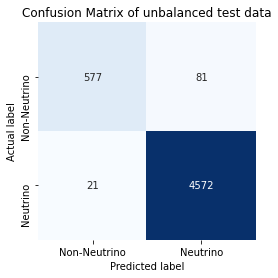

In [25]:
mat = confusion_matrix(test_labels, np.round(predicted_binary2))
labels = ['Non-Neutrino', 'Neutrino']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.title('Confusion Matrix of unbalanced test data')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Text(91.68, 0.5, 'Actual label')

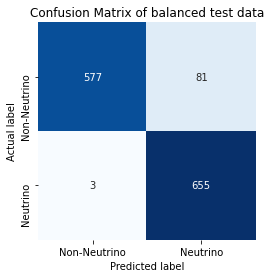

In [27]:
mat = confusion_matrix(test_labels_balanced, np.round(predicted_binary3))
labels = ['Non-Neutrino', 'Neutrino']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.title('Confusion Matrix of balanced test data') 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

From the 2 confusion matrices above we confirm that the accuracy of the model at predicting the not-neutrino catagory is lowers, on the other hand the models ability to predict neutrino is excellent. However this is to be expected as we have much less data of the not-neutrino catagory. 

This could be solved by balancing the train data, however this will drastically reduce the data set.

## Task 2

QE: 0,4,8
Res: 1,5,9
Des: 2,6,10

In [22]:
#splits the test data up by the type of interaction
QE_images = test_images[test_catagory > (0 or 4 or 8)]
Res_images = test_images[test_catagory > (1 or 5 or 9)]
Des_images = test_images[test_catagory > (2 or 6 or 10)]
other_images = test_images[test_catagory > (3 or 7 or 11 or 12 or 13 or 14 or 15 or 16)]

QE_labels = test_labels[test_catagory > (0 or 4 or 8)]
Res_labels = test_labels[test_catagory > (1 or 5 or 9)]
Des_labels = test_labels[test_catagory > (2 or 6 or 10)]
other_labels = test_labels[test_catagory > (3 or 7 or 11 or 12 or 13 or 14 or 15 or 16)]

In [23]:
#finds the accuracy of the model on all the the different type of interaction
loss_QE, acc_QE = model2.evaluate(QE_images, QE_labels, verbose=2)
loss_Res, acc_Res = model2.evaluate(Res_images, Res_labels, verbose=2)
loss_Des, acc_Des = model2.evaluate(Des_images, Des_labels, verbose=2)
loss_other, acc_other = model2.evaluate(other_images, other_labels, verbose=2)

21/21 - 1s - loss: 0.3362 - accuracy: 0.8798 - 762ms/epoch - 36ms/step
112/112 - 4s - loss: 0.0734 - accuracy: 0.9736 - 4s/epoch - 33ms/step
25/25 - 1s - loss: 0.2845 - accuracy: 0.8973 - 844ms/epoch - 34ms/step
21/21 - 1s - loss: 0.3388 - accuracy: 0.8769 - 736ms/epoch - 35ms/step


QE referse to clear tracks, Des refer to messier tracks, and Res is somewhere imbetween. So we would expect QE would have the best accuracy and for the accuracy would go down from Res to Des. However this appears to not be the case as Res, has the best accuracy by quite a large margin.

In [28]:
print(np.shape(QE_labels))
print(np.shape(Res_labels))
print(np.shape(Des_labels))

(649, 1)
(3556, 1)
(789, 1)


By outputting the shape of the catagory arrays we see clearly why this is the case. Res has the most number of data points, which is likely why the accuracy is significanlty higher. Instead of taking a larger data set(which I could do in this example but to simulate a real project and to save time), we will re-train the data on a smaller set with more balanced catagories

In [35]:
#splitting images and labels by their catagory
test_images_QE = test_images[test_catagory > (0 or 4 or 8)]
test_images_Res = test_images[test_catagory > (1 or 5 or 9)]
test_images_Des = test_images[test_catagory > (2 or 6 or 10)]

test_labels_QE = test_labels[test_catagory > (0 or 4 or 8)]
test_labels_Res = test_labels[test_catagory > (1 or 5 or 9)]
test_labels_Des = test_labels[test_catagory > (2 or 6 or 10)]

min_class_size = min(len(test_images_QE), len(test_images_Des))

#balances the data
test_images_QE_balanced = test_images_QE[:min_class_size]
test_images_Res_balanced = test_images_Res[:min_class_size]
test_images_Des_balanced = test_images_Des[:min_class_size]
test_labels_QE_balanced = test_labels_QE[:min_class_size]
test_labels_Res_balanced = test_labels_Res[:min_class_size]
test_labels_Des_balanced = test_labels_Des[:min_class_size]

test_images_balanced_cb = np.concatenate((test_images_QE_balanced, test_images_Res_balanced, test_images_Des_balanced), axis=0)
test_labels_balanced_cb = np.concatenate((test_labels_QE_balanced, test_labels_Res_balanced, test_labels_Des_balanced), axis=0)

In [36]:
#splitting images and labels by their catagory
train_images_QE = train_images[train_catagory > (0 or 4 or 8)]
train_images_Res = train_images[train_catagory > (1 or 5 or 9)]
train_images_Des = train_images[train_catagory > (2 or 6 or 10)]

train_labels_QE = train_labels[train_catagory > (0 or 4 or 8)]
train_labels_Res = train_labels[train_catagory > (1 or 5 or 9)]
train_labels_Des = train_labels[train_catagory > (2 or 6 or 10)]

min_class_size = min(len(train_images_QE), len(train_images_Des))

#balances the data
train_images_QE_balanced = train_images_QE[:min_class_size]
train_images_Res_balanced = train_images_Res[:min_class_size]
train_images_Des_balanced = train_images_Des[:min_class_size]
train_labels_QE_balanced = train_labels_QE[:min_class_size]
train_labels_Res_balanced = train_labels_Res[:min_class_size]
train_labels_Des_balanced = train_labels_Des[:min_class_size]

train_images_balanced_cb = np.concatenate((test_images_QE_balanced, test_images_Res_balanced, test_images_Des_balanced), axis=0)
train_labels_balanced_cb = np.concatenate((test_labels_QE_balanced, test_labels_Res_balanced, test_labels_Des_balanced), axis=0)

In [37]:
fitting=model2.fit(train_images_balanced_cb, train_labels_balanced_cb,batch_size=100, epochs=20, verbose=2)

Epoch 1/20
20/20 - 7s - loss: 0.2566 - accuracy: 0.9147 - 7s/epoch - 343ms/step
Epoch 2/20
20/20 - 7s - loss: 0.1836 - accuracy: 0.9538 - 7s/epoch - 332ms/step
Epoch 3/20
20/20 - 7s - loss: 0.1464 - accuracy: 0.9579 - 7s/epoch - 334ms/step
Epoch 4/20
20/20 - 7s - loss: 0.1373 - accuracy: 0.9625 - 7s/epoch - 326ms/step
Epoch 5/20
20/20 - 7s - loss: 0.1379 - accuracy: 0.9625 - 7s/epoch - 335ms/step
Epoch 6/20
20/20 - 7s - loss: 0.1126 - accuracy: 0.9753 - 7s/epoch - 331ms/step
Epoch 7/20
20/20 - 7s - loss: 0.0998 - accuracy: 0.9718 - 7s/epoch - 331ms/step
Epoch 8/20
20/20 - 7s - loss: 0.0964 - accuracy: 0.9748 - 7s/epoch - 331ms/step
Epoch 9/20
20/20 - 6s - loss: 0.0808 - accuracy: 0.9769 - 6s/epoch - 324ms/step
Epoch 10/20
20/20 - 6s - loss: 0.0821 - accuracy: 0.9805 - 6s/epoch - 324ms/step
Epoch 11/20
20/20 - 7s - loss: 0.0720 - accuracy: 0.9795 - 7s/epoch - 328ms/step
Epoch 12/20
20/20 - 7s - loss: 0.0708 - accuracy: 0.9810 - 7s/epoch - 327ms/step
Epoch 13/20
20/20 - 7s - loss: 0.0696

In [39]:
#finds the accuracy of the model on all the the different type of interaction
loss_QE, acc_QE = model2.evaluate(test_images_QE, test_labels_QE, verbose=2)
loss_Res, acc_Res = model2.evaluate(test_images_Res, test_labels_Res, verbose=2)
loss_Des, acc_Des = model2.evaluate(test_images_Des, test_labels_Des, verbose=2)


21/21 - 1s - loss: 0.0054 - accuracy: 1.0000 - 706ms/epoch - 34ms/step
112/112 - 4s - loss: 0.1546 - accuracy: 0.9373 - 4s/epoch - 32ms/step
25/25 - 1s - loss: 0.0055 - accuracy: 1.0000 - 860ms/epoch - 34ms/step


Now after retraining the model on a balanced data set, the accuracy of the prediction of QE and Des increase to become closer the accuracy of Res. Showing that the model has good prediction for all 3 cataogries, and any discrepencies is mainly due to sampling distribution.